# [aftershoq]: A guide to QCL optimization

Author: Martin Franckie, Sept. 2018

This guide will show you how to:

- Set up optimization environment
- Optimize a model function with different methods
- Optimize quantum cascade structures with a model interface

This guide uses the information algorithm with parallel trials (IAPT) from Strongin and Sergeyev, “Global Optimization with Non-Convex Constraints: Sequential and Parallel Algorithms”, Kluwer Academic Publishers, London (2000), as well as a method based on Gaussian process regression (GP).

Setting up and defining test function:

In [2]:
from aftershoq.interface import NDtestfunc
from aftershoq.numerics import Paraopt, Gaussopt
from aftershoq.utils import HilbertUtil
from hilbert_curve.hilbert import HilbertCurve
import numpy as np
import random as rm
from matplotlib import pyplot as pl

# Number of dimensions:
ND = 2

# generate the Hilbert curve:
p = 7
hc = HilbertCurve( p, ND )
hutil = HilbertUtil( hc )

Now we define the optimization scheme to be used (Paraopt implements IAPT, Guassopt implements Gaussian process regression):

In [3]:
scheme = 1 # 0= IAPT, 1= GP

tol, its, Nproc, r = 0.0005, 100, 1, 0.3

if scheme==0:
    # Creating the optimization object for IAPT:
    opt = Paraopt(tolerance=tol*hutil.imax, maxiter=its, 
                  procmax=Nproc, r=r)
elif scheme==1:
    # Creating the optimization object for GP:
    opt = Gaussopt(tolerance=tol*hutil.imax, maxiter=its, procmax=Nproc,  
                   sigma = 10, l = hutil.imax*0.01, sigma_noise=0.05,
               padding=1000, sigma_noise_max = 5)

The following code blocks can be evaluated separately.
The first one tests the algorithms for a model function (fast check for different schemes and dimensions), the second one uses an actual QCL simulation model to optimize a QCL.

## Test function minimum search

old theta =  [10, 1365.25, 0.05] [ 28.002674]
         Current function value: 27.999143
         Iterations: 1
         Function evaluations: 16
         Gradient evaluations: 4
new theta =  [  9.99663464e+00   1.36525002e+03   1.27693731e-01] [ 27.99914344]
[array([ 6821.24028852])]
old theta =  [10, 1365.25, 0.05] [ 28.002674]
         Current function value: 27.999143
         Iterations: 1
         Function evaluations: 16
         Gradient evaluations: 4
new theta =  [  9.99663464e+00   1.36525002e+03   1.27693731e-01] [ 27.99914344]
[array([ 6821.24028852])]
Converged:  0
old theta =  [10, 1260.2307692307693, 0.05] [ 31.68575181]
         Current function value: 10.716471
         Iterations: 6
         Function evaluations: 42
         Gradient evaluations: 30
new theta =  [  8.61377591e-01   1.26028623e+03   1.52092559e-01] [ 10.71647079]
[array([ 2663.25706683])]
Converged:  0
old theta =  [10, 1170.2142857142858, 0.05] [ 34.56688956]
         Current function value: 8.459065

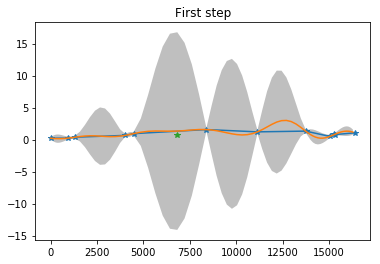

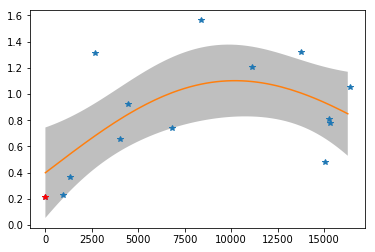

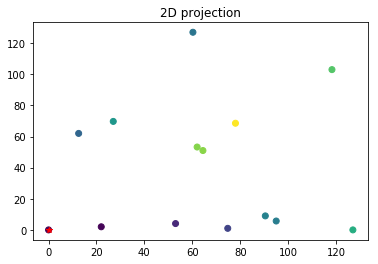

In [4]:
# Model function

# define the model interface. This is a simple test.
model = NDtestfunc(ND)

# initial points are random along the Hilbert curve
N0 = 10
x0 = []
y0 = []
x0.append(0.)
[x0.append(rm.random()*hutil.imax) for _ in range(N0)]
x0.append(hutil.imax)

x0 = np.sort(x0)

# To retreive coordinates, we have to scale by 2^p. opt will minimize,
# hence we append the negative of the merit function:
[y0.append(-model.getMerit(hutil.interp_coords_from_dist(xx)/2.**hutil.p)) 
 for xx in x0]

opt.addpoints(x0, y0)

newx = opt.nextstep()
if newx == -1:
    print("Failed to find new x-points from given input!")
    exit(1)
print(newx)
newy = []
[newy.append(-model.getMerit(hutil.interp_coords_from_dist(xx))) for xx in newx]

if scheme==1:
    xt1 = opt.xt
    mean1 = np.squeeze(opt.mean)
    var1 = np.reshape( np.abs( np.diag( opt.cov ) ), (opt.Nx,1) )


conv = opt.minimize_parameters(model, hutil)

print ("Convergence: " + str(conv) + " after " + str(opt.iter) + " iterations.")

optpointHC = opt.getbest()
optpointND = hutil.interp_coords_from_dist(optpointHC[0])



points = []
xND = []
yND = []
for x in opt.x:
    point = hutil.interp_coords_from_dist(x)
    xND.append(point[0])
    yND.append(point[1])
    points.append(point)
    
# plotting the results:

pl.figure(1)
pl.plot(x0, y0, '-*')

if scheme==1:
    pl.plot(xt1, mean1)
    pl.fill_between(np.squeeze(xt1), mean1-np.squeeze(2*np.sqrt(var1)),
                    mean1+np.squeeze(2*np.sqrt(var1)), 
                    facecolor = "grey", alpha=0.5)
    
pl.plot(newx, newy, '*')
pl.title("First step")

pl.figure(2)
if scheme==0:
    pl.plot(opt.x, opt.y, '-*')
elif scheme==1:
    pl.plot(opt.x, opt.y, '*')
    
pl.plot(opt.getbest()[0], opt.getbest()[1], 'r*')

if scheme==1:
    mean = np.squeeze(opt.mean)
    var = np.reshape( np.abs( np.diag( opt.cov ) ), (opt.Nx,1) )
    pl.plot(opt.xt, mean)
    pl.fill_between(np.squeeze(opt.xt), mean-np.squeeze(2*np.sqrt(var)),
                    mean+np.squeeze(2*np.sqrt(var)), 
                    facecolor = "grey", alpha=0.5)

pl.figure(3)

pl.scatter(xND, yND, c=np.squeeze(opt.y))
pl.title("2D projection")
pl.hold
pl.plot(optpointND[0], optpointND[1], 'r*')

pl.show()



## Optimizing a QC structure with a simulation model

dopindex = []
Dim = 6, p = 7, imax = 4398046511103, pmax = 127
Simulation is running...
Simulation is running...
Simulation is running...


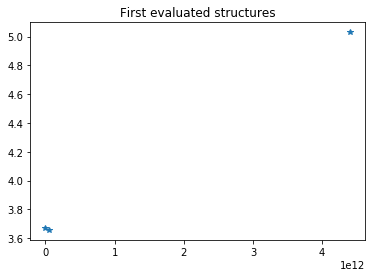

old theta =  [10, 1466015503701.0, 0.05] [ 6.42611302]
         Current function value: 4.637208
         Iterations: 4
         Function evaluations: 27
         Gradient evaluations: 15
new theta =  [  3.64849780e+00   1.46601550e+12   8.44171069e-04] [ 4.63720759]
old theta =  [10, 1099511627775.75, 0.05] [ 9.94303565]
         Current function value: 7.649989
         Iterations: 11
         Function evaluations: 43
         Gradient evaluations: 31
new theta =  [  3.67001292e+00   1.09951163e+12   1.83011519e-05] [ 7.64998927]
old theta =  [10, 879609302220.59998, 0.05] [ 12.92205682]
Optimization terminated successfully.
         Current function value: 9.913332
         Iterations: 21
         Function evaluations: 49
         Gradient evaluations: 49
new theta =  [  3.55043109e+00   8.79609302e+11  -1.30156668e-10] [ 9.91333237]
old theta =  [10, 733007751850.5, 0.05] [ 16.52797079]
         Current function value: 12.855437
         Iterations: 10
         Function evaluations

old theta =  [10, 175921860444.12, 0.05] [ 642.23384622]
Optimization terminated successfully.
         Current function value: 58.844580
         Iterations: 9
         Function evaluations: 23
         Gradient evaluations: 23
new theta =  [  3.66267143e+00   1.75921860e+11   7.82050950e-01] [ 58.84458048]
Converged!
1
old theta =  [10, 169155635042.42307, 0.05] [ 754.7317343]
Optimization terminated successfully.
         Current function value: 60.882626
         Iterations: 8
         Function evaluations: 21
         Gradient evaluations: 21
new theta =  [  3.71723500e+00   1.69155635e+11   7.88362834e-01] [ 60.88262617]
Converged!
1
old theta =  [10, 162890611522.33334, 0.05] [ 753.5482001]
Optimization terminated successfully.
         Current function value: 63.020597
         Iterations: 10
         Function evaluations: 24
         Gradient evaluations: 24
new theta =  [  3.69795517e+00   1.62890612e+11   7.78516124e-01] [ 63.02059708]
Converged!
1
old theta =  [10, 15707308

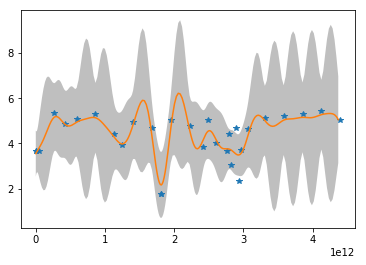

In [5]:
from aftershoq.interface import Isewlab
from aftershoq.qcls import EV2416
from aftershoq.structure import Sgenerator
from aftershoq.numerics.runplatf import Local
from aftershoq.materials import GaAs
import aftershoq.utils.systemutil as su

s = EV2416()

dw = []
[dw.append(l.width*0.10) for l in s.layers]

sg = Sgenerator(s, dw)
# keep binpath = "" if binary is in main path
binpath = ""
su.mkdir("demo/")
wdpath = su.abspath("demo/")
pltfm = Local()

Ns = 3
coords = sg.genRanHilbertStructs(Ns, p)

# Choose your model:
# model = Inegf(binpath, pltfm, GaAs() )
# model = Isewself(binpath, pltfm, [GaAs(), AlGaAs(x=0.15)])
model = Isewlab(binpath + "sewlab", pltfm, GaAs())

model.numpar["efield0"] = -0.150
model.absorption_params["min-photon-energy"] = 0.010
model.absorption_params["max-photon-energy"] = 0.020

model.runStructures(sg.structures, wdpath)
model.waitforproc(3, "Simulation is running...")
model.gatherResults(sg.structures, wdpath)
opt.x = []
opt.y = []
x0, y0 = opt.addEvaldPoints(model, sg, wdpath, coords)

pl.figure(6)
pl.plot(x0, y0, '*')
pl.title("First evaluated structures")
pl.show()

conv = opt.minimize(model, sg, wdpath)

print( "Convergence: " + str(conv) )

pl.figure(7)
pl.plot(opt.x,opt.y,'*')
if scheme==1:
    mean = np.squeeze(opt.mean)
    var = np.reshape( np.abs( np.diag( opt.cov ) ), (opt.Nx,1) )
    pl.plot(opt.xt, mean)
    pl.fill_between(np.squeeze(opt.xt), mean-np.squeeze(2*np.sqrt(var)),
                    mean+np.squeeze(2*np.sqrt(var)), 
                    facecolor = "grey", alpha=0.5)
pl.show()